**Imports:**

In [1]:
from types import SimpleNamespace
from copy import deepcopy

import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})

import ipywidgets as widgets

$$
\begin{align}
v(p,w,M,\overline{L}) &=\max_{L\in[0,\overline{L}]}\ln\left(\frac{M+W(L)}{p}\right)-\nu\frac{L^{1+\frac{1}{\epsilon}}}{1+\frac{1}{\epsilon}} \\
&=\max_{L\in\{0,\frac{w}{\kappa},\overline{L}\}\cup(0,\frac{w}{\kappa})\cup(\frac{w}{\kappa},\overline{L})}\ln\left(\frac{W(L)+M}{p}\right)-\nu\frac{L^{1+\frac{1}{\epsilon}}}{1+\frac{1}{\epsilon}}
\end{align}
$$

# Functions

**Basic functions:**

In [2]:
def W_func(L,par):
    """ wage W as function of labour supply L """
    
    return (1-par.tau_0)*par.w*L - par.tau_1*np.fmax(par.w*L-par.kappa,0.0)

def W_prime_func(L,par):
    """ marginal wage W as function of labour supply L """
    
    if L < par.kappa/par.w:
        return (1-par.tau_0)*par.w
    else:
        return (1-par.tau_0-par.tau_1)*par.w

def disutility_L(L,par):
    """ disutility of labor supply """
    
    return par.nu*L**(1+1/par.epsilon)/(1+1/par.epsilon)

def utility(L,par):
    """ utility as function of labor supply L with maximum consumption """

    C = W_func(L,par) + par.M
    return np.log(C) - disutility_L(L,par)

def FOC(L,par):
    """ error in first order condition (FOC) given labor supply"""
    
    # a. LHS
    LHS = L
    
    # b. RHS
    marginal_real_wage = W_prime_func(L,par)/par.p
    marginal_utility = 1/((W_func(L,par)+par.M)/par.p)
    RHS = (1.0/par.nu*marginal_real_wage*marginal_utility)**par.epsilon
    
    # c. error
    return LHS-RHS

**Solve problem:**

In [3]:
def solve(par,do_print=False):

    # a. L = 0.0
    u0 = utility(0.0,par)
    
    # b. L = Lmax
    umax = utility(par.Lmax,par)
    
    # c. L = kappa/w
    L_mid = par.kappa/par.w
    umid = utility(L_mid,par)
    
    # d. left interval
    sign_LL = np.sign(FOC(1e-8,par))
    sign_LR = np.sign(FOC(L_mid-1e-8,par))
    
    if not sign_LL == sign_LR:
        sol_L = optimize.bisect(FOC,1e-8,L_mid-1e-8,args=(par,))
        uL = utility(sol_L,par)
    else:
        sol_L = np.nan
        uL = np.nan
        
    # e. right interval
    sign_RL = np.sign(FOC(L_mid+1e-8,par))
    sign_RR = np.sign(FOC(par.Lmax-1e-8,par))
    
    if not sign_RL == sign_RR:
        sol_R = optimize.bisect(FOC,L_mid+1e-8,par.Lmax-1e-8,args=(par,))
        uR = utility(sol_R,par)
    else:
        sol_R = np.nan       
        uR = np.nan
    
    # f. global maksimum
    i_opt = np.nanargmax([u0,uL,umid,uR,umax])
    
    if i_opt == 0:
        L_opt = 0.0
    elif i_opt == 1:
        L_opt = sol_L
    elif i_opt == 2:
        L_opt = L_mid
    elif i_opt == 3:
        L_opt = sol_R
    elif i_opt == 4:
        L_opt = par.Lmax
    
    return L_opt,L_mid,sol_L,sol_R

**Plotting functions:**

In [4]:
def plot_point(ax,L,par,marker,color):
    
    R_opt = par.Lmax-L
    C_opt = par.M+W_func(L,par)
    
    ax.scatter(R_opt,C_opt,marker=marker,color=color)    

In [5]:
def plot_indiff(ax,L,par,color):
    
    u_opt = utility(L,par)
    L_indiff = np.linspace(0.1*L,2*L,1000)
    R_indiff = par.Lmax-L_indiff
    C_indiff = np.exp(u_opt + disutility_L(L_indiff,par))  
    ax.plot(R_indiff,C_indiff,color=color)
        

In [6]:
def plot_optimization(par,w=None):
    """ plot solution for different wage levels """
        
    fig = plt.figure(figsize=(6,6/1.5),dpi=100)
    ax = fig.add_subplot(1,1,1)
    
    R_vec = np.linspace(0,par.Lmax,1000)
    
    C_max_vec = par.M + W_func(par.Lmax-R_vec,par)
    ax.plot(R_vec,C_max_vec,color='black',zorder=1)
    ax.plot([par.Lmax,par.Lmax],[0,par.M],color='black',zorder=1)
    
    L_opt,L_mid,sol_L,sol_R = solve(par,do_print=False)
    
    i = 1
    for L_ in [L_mid,sol_L,sol_R]:
        
        if np.isnan(L_): continue
        if np.isclose(L_,L_opt): continue
        plot_point(ax,L_,par,marker='s',color=colors[i])
        plot_indiff(ax,L_,par,color=colors[i])
        i += 1
    
    plot_point(ax,L_opt,par,marker='*',color=colors[0])
    plot_indiff(ax,L_opt,par,color=colors[0])
    
    ax.set_xlabel('$R$')
    ax.set_ylabel('$C$')
    
    ax.set_xlim([0,2.5])
    ax.set_ylim([0,35]) 

# Solve

In [7]:
par = SimpleNamespace()

# utility 
par.epsilon = 1.0
par.nu = 0.35

# income
par.M = 10.0
par.Lmax = 2.0

# numeraire
par.p = 1.0

# taxes
par.tau_0 = 0.40
par.tau_1 = 0.10
par.kappa = 20.0

# wage
par.w = 25

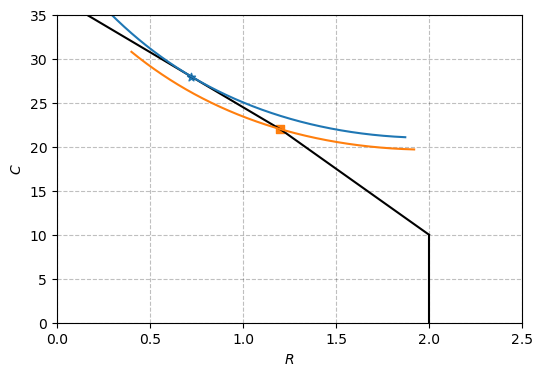

In [8]:
plot_optimization(par)   

tau_1 = 0.2


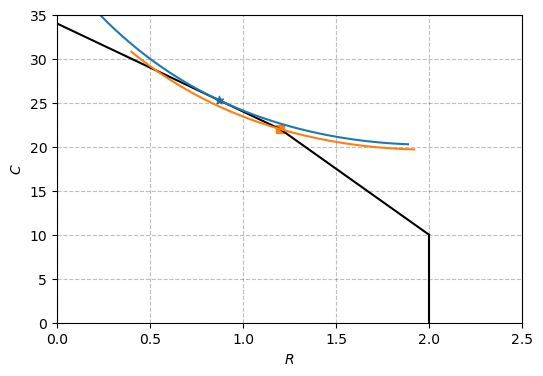

tau_1 = 0.3


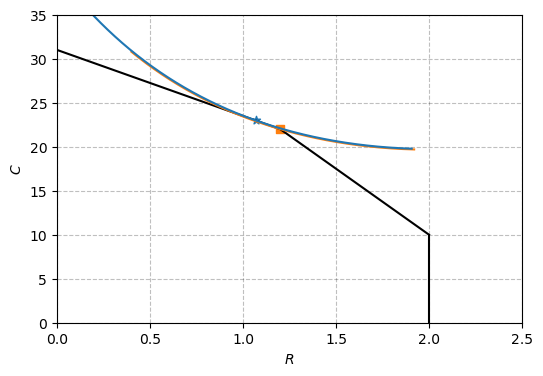

tau_1 = 0.4


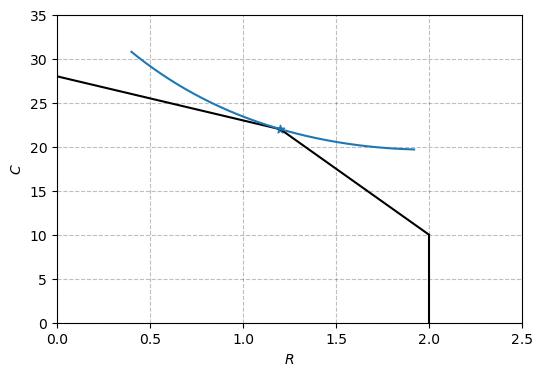

In [9]:
tau_1_old = par.tau_1
for tau_1 in [0.20,0.30,0.40]:
    par.tau_1 = tau_1
    print(f'{tau_1 = }')
    plot_optimization(par)
    plt.show()
par.tau_1 = tau_1_old